<a href="https://colab.research.google.com/github/frostkose/MTE-Line-Balancing/blob/main/MTE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MTE 2 balancing version 2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, deque
import matplotlib.cm as cm
import openpyxl

class PrecedenceLineBalancing:
    def __init__(self, tasks, BF=15, num_workers=6, tolerance=0.1):
        self.tasks = tasks
        self.BF = BF
        self.tolerance = tolerance  # tolérance de dépassement
        self.num_workers = num_workers
        self.workstations = []
        self.workstation_times = []
        self.task_assigned = {}

    def topological_sort(self):
        graph = defaultdict(list)
        in_degree = defaultdict(int)

        for task, info in self.tasks.items():
            for pred in info['predecessors']:
                graph[pred].append(task)
                in_degree[task] += 1
            if task not in in_degree:
                in_degree[task] = 0

        queue = deque([node for node in in_degree if in_degree[node] == 0])
        sorted_tasks = []

        while queue:
            node = queue.popleft()
            sorted_tasks.append(node)
            for neighbor in graph[node]:
                in_degree[neighbor] -= 1
                if in_degree[neighbor] == 0:
                    queue.append(neighbor)

        if len(sorted_tasks) != len(self.tasks):
            raise ValueError("Cycle detected in task precedence!")

        return sorted_tasks

    def balance_line(self):
        sorted_tasks = self.topological_sort()
        max_allowed = self.BF * (1 + self.tolerance)

        for task in sorted_tasks:
            duration = self.tasks[task]['duration']

            # Cas spécial : si duration > max_allowed et proche de n * BF
            ratio = duration / self.BF
            n = round(ratio)
            if duration > max_allowed and abs(ratio - n) <= self.tolerance:
                for i in range(n):
                    self.workstations.append([(f"{task}_part{i+1}", duration / n)])
                    self.workstation_times.append(duration / n)
                self.task_assigned[task] = len(self.workstations) - 1
                continue

            # Essayer de l'affecter à un poste existant
            assigned = False
            for i in range(len(self.workstations)):
                new_total = self.workstation_times[i] + duration
                if new_total <= max_allowed:
                    if all(pred in self.task_assigned and self.task_assigned[pred] <= i
                           for pred in self.tasks[task]['predecessors']):
                        self.workstations[i].append((task, duration))
                        self.workstation_times[i] += duration
                        self.task_assigned[task] = i
                        assigned = True
                        break

            # Sinon, créer un nouveau poste
            if not assigned:
                self.workstations.append([(task, duration)])
                self.workstation_times.append(duration)
                self.task_assigned[task] = len(self.workstations) - 1

    def plot_distribution(self):
        labels = [f"Poste {i+1}" for i in range(len(self.workstations))]
        values = self.workstation_times

        plt.figure(figsize=(10, 5))
        cmap = cm.get_cmap('tab20')
        color_map = {}
        color_index = 0

        bottom = np.zeros(len(self.workstations))
        for i, tasks in enumerate(self.workstations):
            for task, duration in tasks:
                if task not in color_map:
                    color_map[task] = cmap(color_index % 20)
                    color_index += 1
                plt.bar(labels[i], duration, bottom=bottom[i], color=color_map[task], label=task if task not in plt.gca().get_legend_handles_labels()[1] else "")
                bottom[i] += duration

        plt.axhline(y=self.BF, color='r', linestyle='--', label=f'Base de Temps (BF={self.BF:.2f})')

        for i, val in enumerate(values):
            plt.text(i, val + 0.2, f"{val:.2f}", ha='center', va='bottom')

        plt.title('Distribution des Temps avec contraintes de précédence (couleur unique par opération)')
        plt.xlabel('Postes de Travail')
        plt.ylabel('Temps (minutes)')
        plt.ylim(0, max(values + [self.BF]) + 2)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()

    def display_assignment(self):
        print("\nRépartition des opérations :")
        for i, (ws, t) in enumerate(zip(self.workstations, self.workstation_times)):
            if ws:
                ops = [f"{task} ({dur:.2f} min)" for task, dur in ws]
                print(f"Poste {i+1} ({t:.2f} min): {', '.join(ops)}")

    def calculate_kpis(self):
        N = len(self.workstations)
        T_C = max(self.workstation_times) if N > 0 else 0
        total_time = sum(self.workstation_times)

        efficiency = total_time / (N * T_C) if T_C > 0 else 0
        smoothness = np.sqrt(sum((T_C - t) ** 2 for t in self.workstation_times))
        balance_delay = (N * T_C - total_time) / (N * T_C) if T_C > 0 else 0

        return {
            'Efficience maximale': round(efficiency * 100, 2),
            'Indice de fluidité (déséquilibre)': round(smoothness, 3),
            'Délai équilibrage (%)': round(balance_delay * 100, 2),
            'Temps de cycle': round(T_C, 3),
            'Postes utilisés': N
        }

    def export_results_to_excel(self,workstations, kpis, output_path="gamme_data.xlsx", sheet_name="Résultats_60511"):
      from openpyxl import load_workbook
      from openpyxl.utils import get_column_letter

      wb = load_workbook(output_path)
      if sheet_name in wb.sheetnames:
          del wb[sheet_name]
      ws = wb.create_sheet(sheet_name)

      ws.append(["Poste", "Tâche", "Durée (min)"])
      for i, ws_tasks in enumerate(workstations):
          for task, duration in ws_tasks:
              ws.append([f"Poste {i+1}", task, round(duration, 2)])

      ws.append([])
      ws.append(["KPI", "Valeur"])
      for k, v in kpis.items():
          ws.append([k, v])

      wb.save(output_path)

#79615

In [ ]:
import pandas as pd
data2=pd.read_excel("gamme_data.xlsx",sheet_name="79615",header=1)
data2=pd.DataFrame(data2)
data2

,Code,Libellé,Machine,Temps,Pred
0,&SF1TCOENC007,collecter encol \ncoupe précise,$COL-2AIG,0.437,NaN
1,&SF1TCOEMM001,collecter emmanchure+bretelle,$COL-2AIG,0.453,NaN
2,&SF1BCOB0D003,"collecter devt,dos,bas body",$COL-2AIG,0.271,NaN
3,&SF1BMOBOD003,montage body débardeur,$SURJ-3F,0.606,"&SF1TCOENC007, &SF1TCOEMM001, &SF1BCOB0D003"
4,&SF1BPOPRE001,poser 3 pressions sur bas body,$PRESSION-12,0.297,&SF1BMOBOD003
5,C4F1LCONBCLSG4/3,visitage-pliage-condt standard GMS/3,MAIN,0.974,&SF1BPOPRE001
6,NaN,NaN,TOTAL,3.038,NaN


In [ ]:

data2 = data2.rename(columns={"Code": "OPERATION", "Machine": "MACHINE", "Temps": "TIME","Pred":"PRED"})
data2 = data2.drop("Libellé", axis=1)
data2 = data2.iloc[:-1]

data2

,OPERATION,MACHINE,TIME,PRED
0,&SF1TCOENC007,$COL-2AIG,0.437,NaN
1,&SF1TCOEMM001,$COL-2AIG,0.453,NaN
2,&SF1BCOB0D003,$COL-2AIG,0.271,NaN
3,&SF1BMOBOD003,$SURJ-3F,0.606,"&SF1TCOENC007, &SF1TCOEMM001, &SF1BCOB0D003"
4,&SF1BPOPRE001,$PRESSION-12,0.297,&SF1BMOBOD003
5,C4F1LCONBCLSG4/3,MAIN,0.974,&SF1BPOPRE001


In [ ]:
data2_2=data2.copy()

In [ ]:
data2_2['PRED']=data2_2['PRED'].apply(
    lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(',')]
    )
data2_2

,OPERATION,MACHINE,TIME,PRED
0,&SF1TCOENC007,$COL-2AIG,0.437,[]
1,&SF1TCOEMM001,$COL-2AIG,0.453,[]
2,&SF1BCOB0D003,$COL-2AIG,0.271,[]
3,&SF1BMOBOD003,$SURJ-3F,0.606,"[&SF1TCOENC007, &SF1TCOEMM001, &SF1BCOB0D003]"
4,&SF1BPOPRE001,$PRESSION-12,0.297,[&SF1BMOBOD003]
5,C4F1LCONBCLSG4/3,MAIN,0.974,[&SF1BPOPRE001]


In [ ]:
tasks_79615={line['OPERATION']:{'predecessors': line['PRED'], 'duration': line['TIME']} for _,line in data2_2.iterrows()}
tasks_79615

{'&SF1TCOENC007': {'predecessors': [], 'duration': 0.437},
 '&SF1TCOEMM001': {'predecessors': [], 'duration': 0.453},
 '&SF1BCOB0D003': {'predecessors': [], 'duration': 0.271},
 '&SF1BMOBOD003': {'predecessors': ['&SF1TCOENC007',
   '&SF1TCOEMM001',
   '&SF1BCOB0D003'],
  'duration': 0.606},
 '&SF1BPOPRE001': {'predecessors': ['&SF1BMOBOD003'], 'duration': 0.297},
 'C4F1LCONBCLSG4/3': {'predecessors': ['&SF1BPOPRE001'], 'duration': 0.974}}

In [ ]:
import math
time_total=sum([ v['duration'] for v in tasks_79615.values()]) # cumul de temps des opérations
print('time_total :',time_total)
cust_demand=4400 #par semaine
open_days=5
working_time=7 #heures de travail hors pauses
TT=working_time*60*open_days/cust_demand # calcul de Takt Time
print('customer demand : ',cust_demand)
print('Takt Time : ',TT)
num_operators=round(time_total/TT)
print('nombre des operateurs :',num_operators)

time_total : 3.0380000000000003
customer demand :  4400
Takt Time :  0.4772727272727273
nombre des operateurs : 6


In [ ]:
df_79615=pd.DataFrame([
    {'OPERATION': task, 'MACHINE': 'GEN', 'TIME': props['duration']}
    for task, props in tasks_79615.items()
])


Répartition des opérations :
Poste 1 (0.44 min): &SF1TCOENC007 (0.44 min)
Poste 2 (0.45 min): &SF1TCOEMM001 (0.45 min)
Poste 3 (0.27 min): &SF1BCOB0D003 (0.27 min)
Poste 4 (0.61 min): &SF1BMOBOD003 (0.61 min)
Poste 5 (0.30 min): &SF1BPOPRE001 (0.30 min)
Poste 6 (0.49 min): C4F1LCONBCLSG4/3_part1 (0.49 min)
Poste 7 (0.49 min): C4F1LCONBCLSG4/3_part2 (0.49 min)


<ipython-input-22-abc4ef0a4db4>:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


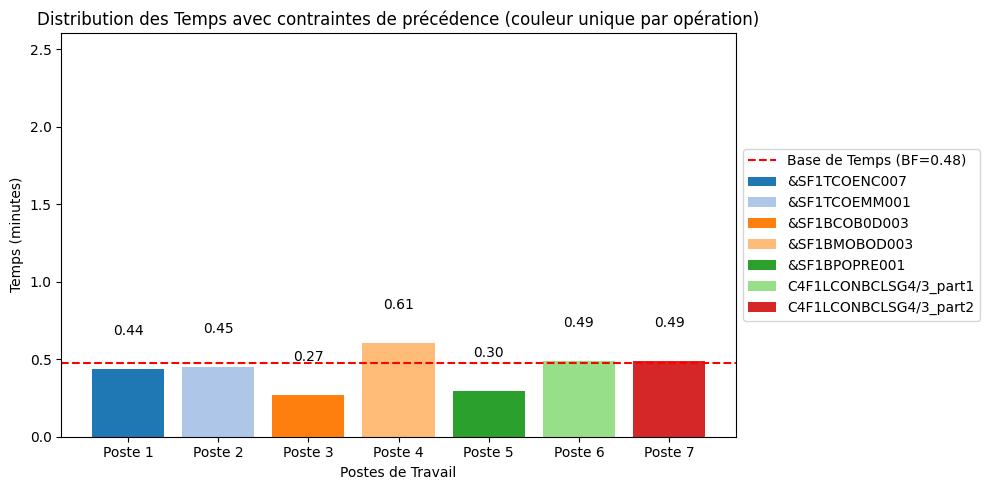

In [ ]:

#from line_balancing_with_precedence import PrecedenceLineBalancing  # ou directement si défini dans le même fichier


balancer = PrecedenceLineBalancing(tasks_79615, BF=TT, num_workers=num_operators,tolerance=0.05)
#balancer = PrecedenceLineBalancing(tasks_79615, BF=0.485, num_workers=num_operators,tolerance=0.05)
balancer.balance_line()

balancer.display_assignment()

balancer.plot_distribution()


In [ ]:
kpis = balancer.calculate_kpis()
for k, v in kpis.items():
    print(f"{k} : {v}")


Efficience maximale : 71.62
Indice de fluidité (déséquilibre) : 0.537
Délai équilibrage (%) : 28.38
Temps de cycle : 0.606
Postes utilisés : 7


#60511

In [ ]:
data3=pd.read_excel("gamme_data.xlsx",sheet_name="60511",header=1)
data3=pd.DataFrame(data3)
data3

,Code,Libellé,Machine,Temps,PRED
0,&SFTPIQMANC003,revers bas manches 2 replis 3arrêts+arrêts des...,$PQ.1AIG,2.359,NaN
1,&SFTASSEPAU000,ass 1ere épaule avec cordonnet,$SURJ-3F,0.183,NaN
2,&SFTCOLENCO001,collecter encolure à plat avec 1 vignette en d...,$COL-2AIG,0.293,NaN
3,&SFTASSEPAU001,ass 2ème épaule en bloc note avec cordonnet,$SURJ-3F,0.162,&SFTCOLENCO001
4,&SFTMONMANC003,monter manches à plat avec en complément\nsurj...,$SURJ-3F,0.573,&SFTASSEPAU001
5,&SFTFERMCCO000,fermer manches et côtés+2RC+vignette,$SURJ-3F,0.998,&SFTASSEPAU000
6,&SFTOURBCOR000,ourler TS invisible en rond,$OURL-2F-INV,0.327,"&SFTCOLENCO001, &SFTFERMCCO000"
7,C4F1ECONMAXTS4,visitage-pliage-condit.selectif standard,MAIN,1.231,"&SFTPIQMANC003, &SFTASSEPAU000"
8,C4F1JCCONMAXTS4,visitage-pliage-condit.selectif standard,MAIN,0.000,"&SFTMONMANC003, &SFTPIQMANC003"
9,NaN,NaN,TOTAL,6.126,NaN


In [ ]:

data3 = data3.rename(columns={"Code": "OPERATION", "Machine": "MACHINE", "Temps": "TIME","Pred":"PRED"})
data3 = data3.drop("Libellé", axis=1)
data3 = data3.iloc[:-1]

data3

,OPERATION,MACHINE,TIME,PRED
0,&SFTPIQMANC003,$PQ.1AIG,2.359,NaN
1,&SFTASSEPAU000,$SURJ-3F,0.183,NaN
2,&SFTCOLENCO001,$COL-2AIG,0.293,NaN
3,&SFTASSEPAU001,$SURJ-3F,0.162,&SFTCOLENCO001
4,&SFTMONMANC003,$SURJ-3F,0.573,&SFTASSEPAU001
5,&SFTFERMCCO000,$SURJ-3F,0.998,&SFTASSEPAU000
6,&SFTOURBCOR000,$OURL-2F-INV,0.327,"&SFTCOLENCO001, &SFTFERMCCO000"
7,C4F1ECONMAXTS4,MAIN,1.231,"&SFTPIQMANC003, &SFTASSEPAU000"
8,C4F1JCCONMAXTS4,MAIN,0.000,"&SFTMONMANC003, &SFTPIQMANC003"


In [ ]:
data3_2=data3.copy()

In [ ]:
data3_2['PRED']=data3_2['PRED'].apply(
    lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(',')]
    )
data3_2

,OPERATION,MACHINE,TIME,PRED
0,&SFTPIQMANC003,$PQ.1AIG,2.359,[]
1,&SFTASSEPAU000,$SURJ-3F,0.183,[]
2,&SFTCOLENCO001,$COL-2AIG,0.293,[]
3,&SFTASSEPAU001,$SURJ-3F,0.162,[&SFTCOLENCO001]
4,&SFTMONMANC003,$SURJ-3F,0.573,[&SFTASSEPAU001]
5,&SFTFERMCCO000,$SURJ-3F,0.998,[&SFTASSEPAU000]
6,&SFTOURBCOR000,$OURL-2F-INV,0.327,"[&SFTCOLENCO001, &SFTFERMCCO000]"
7,C4F1ECONMAXTS4,MAIN,1.231,"[&SFTPIQMANC003, &SFTASSEPAU000]"
8,C4F1JCCONMAXTS4,MAIN,0.000,"[&SFTMONMANC003, &SFTPIQMANC003]"


In [ ]:
tasks_60511={line['OPERATION']:{'predecessors': line['PRED'], 'duration': line['TIME']} for _,line in data3_2.iterrows()}
tasks_60511

{'&SFTPIQMANC003': {'predecessors': [], 'duration': 2.359},
 '&SFTASSEPAU000': {'predecessors': [], 'duration': 0.183},
 '&SFTCOLENCO001': {'predecessors': [], 'duration': 0.293},
 '&SFTASSEPAU001': {'predecessors': ['&SFTCOLENCO001'], 'duration': 0.162},
 '&SFTMONMANC003': {'predecessors': ['&SFTASSEPAU001'], 'duration': 0.573},
 '&SFTFERMCCO000': {'predecessors': ['&SFTASSEPAU000'], 'duration': 0.998},
 '&SFTOURBCOR000': {'predecessors': ['&SFTCOLENCO001', '&SFTFERMCCO000'],
  'duration': 0.327},
 'C4F1ECONMAXTS4': {'predecessors': ['&SFTPIQMANC003', '&SFTASSEPAU000'],
  'duration': 1.231},
 'C4F1JCCONMAXTS4': {'predecessors': ['&SFTMONMANC003', '&SFTPIQMANC003'],
  'duration': 0.0}}

In [ ]:
import math
time_total=sum([ v['duration'] for v in tasks_60511.values()]) # cumul de temps des opérations
print('time_total :',time_total)
cust_demand=2160 #par semaine
open_days=6
working_time=7 #heures de travail hors pauses
TT=working_time*60*open_days/cust_demand # calcul de Takt Time
print('customer demand : ',cust_demand)
print('Takt Time : ',TT)
num_operators=round(time_total/TT)
print('nombre des postes :',num_operators)

time_total : 6.1259999999999994
customer demand :  2160
Takt Time :  1.1666666666666667
nombre des postes : 5


In [ ]:
df_60511=pd.DataFrame([
    {'OPERATION': task, 'MACHINE': 'GEN', 'TIME': props['duration']}
    for task, props in tasks_60511.items()
])


Répartition des opérations :
Poste 1 (1.18 min): &SFTPIQMANC003_part1 (1.18 min)
Poste 2 (1.18 min): &SFTPIQMANC003_part2 (1.18 min)
Poste 3 (1.21 min): &SFTASSEPAU000 (0.18 min), &SFTCOLENCO001 (0.29 min), &SFTASSEPAU001 (0.16 min), &SFTMONMANC003 (0.57 min), C4F1JCCONMAXTS4 (0.00 min)
Poste 4 (1.00 min): &SFTFERMCCO000 (1.00 min)
Poste 5 (1.23 min): C4F1ECONMAXTS4 (1.23 min)
Poste 6 (0.33 min): &SFTOURBCOR000 (0.33 min)


<ipython-input-22-abc4ef0a4db4>:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


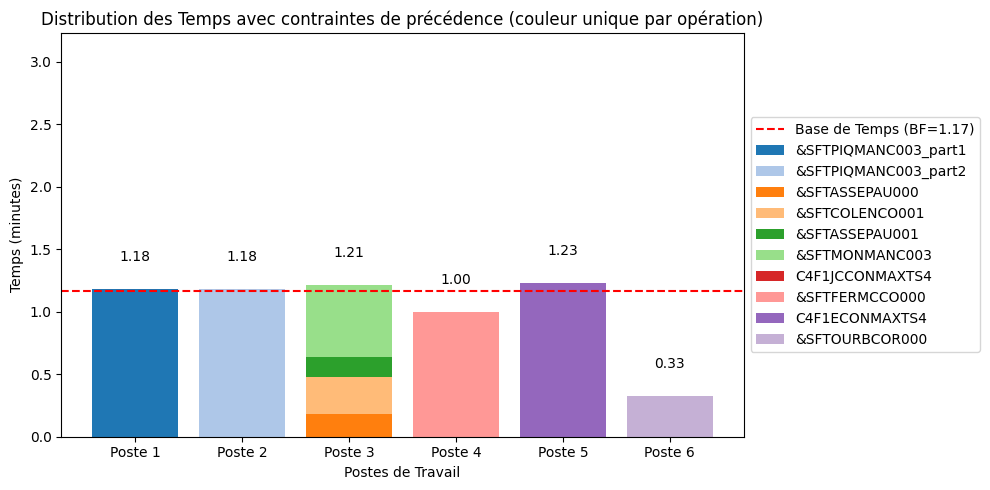

In [ ]:

#from line_balancing_with_precedence import PrecedenceLineBalancing  # ou directement si défini dans le même fichier


balancer2 = PrecedenceLineBalancing(tasks_60511, BF=TT, num_workers=num_operators,tolerance=0.05)
#balancer2 = PrecedenceLineBalancing(tasks_60511, BF=1.18, num_workers=num_operators,tolerance=0.05)
balancer2.balance_line()
balancer2.display_assignment()
balancer2.plot_distribution()


In [ ]:
kpis = balancer2.calculate_kpis()
for k, v in kpis.items():
    print(f"{k} : {v}")


Efficience maximale : 82.94
Indice de fluidité (déséquilibre) : 0.937
Délai équilibrage (%) : 17.06
Temps de cycle : 1.231
Postes utilisés : 6


#any file type 1


In [ ]:
def mte_balancing(gamme_name,file_name="gamme_data.xlsx",cust_demand=1400,open_days=6,working_time=7):
  data=pd.read_excel(file_name,sheet_name=gamme_name,header=1)
  data=pd.DataFrame(data)
  data = data.rename(columns={"Code": "OPERATION", "Machine": "MACHINE", "Temps": "TIME","Pred":"PRED"})
  data = data.drop("Libellé", axis=1)
  data = data.iloc[:-1]
  data_2=data.copy()
  data_2['PRED']=data_2['PRED'].apply(
    lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(',')]
    )
  tasks={line['OPERATION']:{'predecessors': line['PRED'], 'duration': line['TIME']} for _,line in data_2.iterrows()}
  time_total=sum([ v['duration'] for v in tasks.values()]) # cumul de temps des opérations
  print('time_total :',time_total)
  cust_demand=cust_demand #par semaine
  open_days=open_days
  working_time=working_time #heures de travail hors pauses
  TT=working_time*60*open_days/cust_demand # calcul de Takt Time
  print('customer demand : ',cust_demand)
  print('Takt Time : ',TT)
  num_operators=round(time_total/TT)
  print('nombre des operateurs :',num_operators)
  balancer = PrecedenceLineBalancing(tasks, BF=TT, num_workers=num_operators,tolerance=0.05)
  balancer.balance_line()
  balancer.display_assignment()
  balancer.plot_distribution()
  kpis = balancer.calculate_kpis()
  for k, v in kpis.items():
    print(f"{k} : {v}")
      # Export
  balancer.export_results_to_excel(balancer.workstations, balancer.calculate_kpis(), output_path=file_name, sheet_name=f"Résultats_{gamme_name}")






**61228**

time_total : 2.779
customer demand :  4300
Takt Time :  0.586046511627907
nombre des operateurs : 5

Répartition des opérations :
Poste 1 (0.46 min): &SFTCOLENCO007 (0.46 min)
Poste 2 (0.48 min): &SFTCOLEMMA000 (0.48 min), C4F1ECONCHBSS4 (0.00 min)
Poste 3 (0.57 min): C4F1BCONCHBSS4_part1 (0.57 min)
Poste 4 (0.57 min): C4F1BCONCHBSS4_part2 (0.57 min)
Poste 5 (0.43 min): &SFTASSCOTE020 (0.43 min), C4F1JCONCHBSS4 (0.00 min)
Poste 6 (0.26 min): &SFTOURBCOR000 (0.26 min)


<ipython-input-22-abc4ef0a4db4>:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


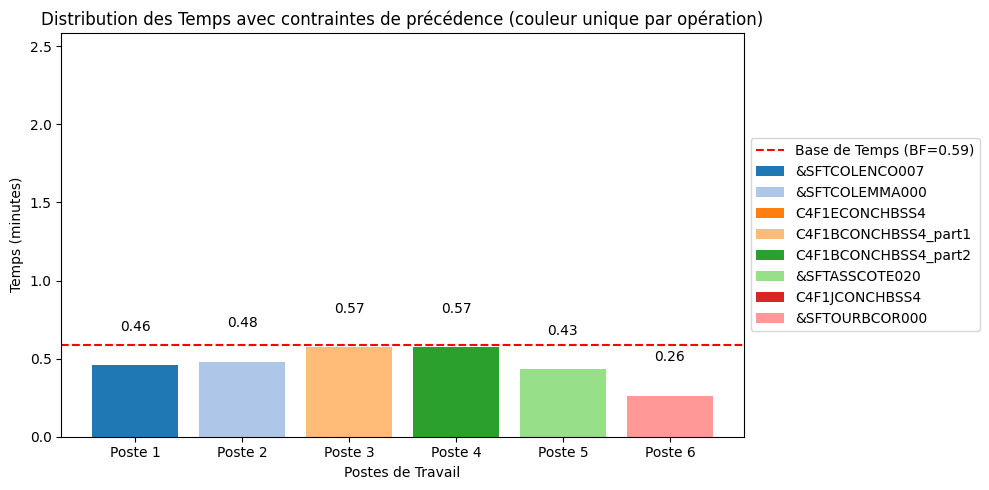

Efficience maximale : 80.83
Indice de fluidité (déséquilibre) : 0.371
Délai équilibrage (%) : 19.17
Temps de cycle : 0.573
Postes utilisés : 6


In [ ]:
mte_balancing("61228",cust_demand=4300)

**61228(3)**

time_total : 2.9930000000000003
customer demand :  2100
Takt Time :  1.2
nombre des operateurs : 2

Répartition des opérations :
Poste 1 (1.00 min): &SFTCOLENCO007 (0.48 min), &SFTCOLEMMA000 (0.53 min)
Poste 2 (0.78 min): &SFTASSCOTE020 (0.49 min), &SFTOURBCOR000 (0.28 min), C4F1BCONCHBSS4 (0.00 min), C4F1ECONCHBSS4 (0.00 min)
Poste 3 (1.21 min): C4F1JCONCHBSS4 (1.21 min)


<ipython-input-22-abc4ef0a4db4>:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


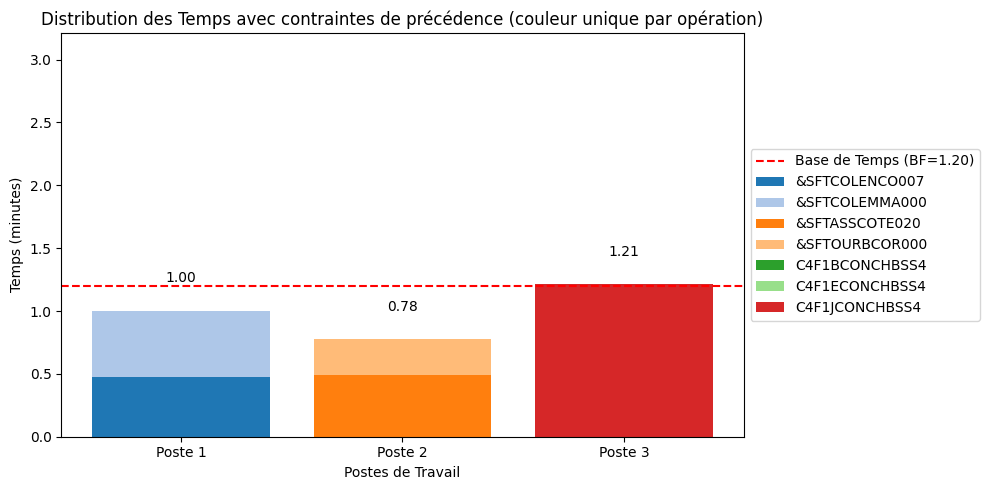

Efficience maximale : 82.25
Indice de fluidité (déséquilibre) : 0.484
Délai équilibrage (%) : 17.75
Temps de cycle : 1.213
Postes utilisés : 3


In [ ]:
mte_balancing("61228 (3)",cust_demand=2100)

#SPT

In [ ]:
data_spt=pd.read_excel("gamme_data.xlsx",sheet_name="79615",header=1)
data_spt=pd.DataFrame(data_spt)
data_spt = data_spt.rename(columns={"Code": "OPERATION", "Machine": "MACHINE", "Temps": "TIME","Pred":"PRED"})
data_spt = data_spt.drop("Libellé", axis=1)
data_spt = data_spt.iloc[:-1]
data_spt_2=data_spt.copy()
data_spt_2['PRED'] = data_spt_2['PRED'].astype(str)

data_spt_2['PRED']=data_spt_2['PRED'].apply(
    # If the string is 'nan', return an empty list, otherwise split and strip
    lambda x: [] if x == 'nan' else [item.strip() for item in x.split(',')]
)

data_spt_2


,OPERATION,MACHINE,TIME,PRED
0,&SF1TCOENC007,$COL-2AIG,0.437,[]
1,&SF1TCOEMM001,$COL-2AIG,0.453,[]
2,&SF1BCOB0D003,$COL-2AIG,0.271,[]
3,&SF1BMOBOD003,$SURJ-3F,0.606,"[&SF1TCOENC007, &SF1TCOEMM001, &SF1BCOB0D003]"
4,&SF1BPOPRE001,$PRESSION-12,0.297,[&SF1BMOBOD003]
5,C4F1LCONBCLSG4/3,MAIN,0.974,[&SF1BPOPRE001]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd # Make sure pandas is imported here

# Données des tâches
# Use data_spt_2 instead of data_spt to ensure predecessors are handled correctly
tasks={line['OPERATION']:{'predecessors': line['PRED'], 'duration': line['TIME']} for _,line in data_spt_2.iterrows()}
time_total=sum([ v['duration'] for v in tasks.values()]) # cumul de temps des opérations
print('time_total :',time_total)
cust_demand=2200 #cust_demand #par semaine
open_days=6 #open_days
working_time=7 #working_time #heures de travail hors pauses
TT=working_time*60*open_days/cust_demand # calcul de Takt Time
print('customer demand : ',cust_demand)
print('Takt Time : ',TT)
num_operators=round(time_total/TT)
print('nombre des operateurs :',num_operators)

time_total : 3.0380000000000003
customer demand :  2200
Takt Time :  1.1454545454545455
nombre des operateurs : 3


<ipython-input-46-ddb8fb5aa4df>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(tasks))  # Get enough colors for all unique tasks


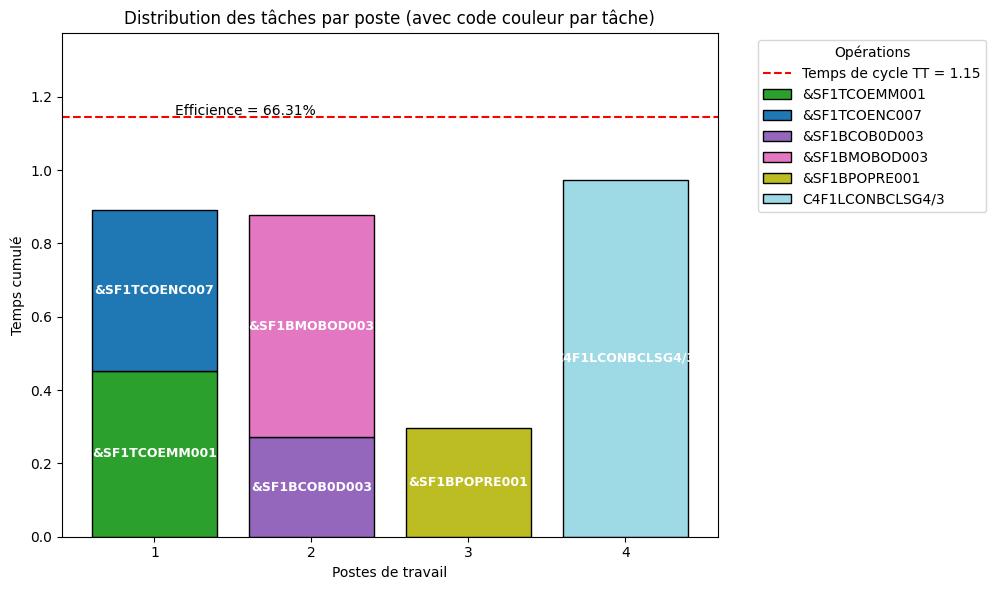

In [ ]:

# Algorithme de répartition
def spt_balanced_line(tasks, TT, num_workstations):
    assigned_tasks = set()
    task_durations = {task: info['duration'] for task, info in tasks.items()}
    # This line will now work correctly because predecessors are lists
    predecessors = {task: set(info['predecessors']) for task, info in tasks.items()}
    task_remaining = set(tasks.keys())
    workstations = []

    while task_remaining:
        ws_tasks = []
        ws_time = 0

        while True:
            available_tasks = sorted(
                [t for t in task_remaining if predecessors[t].issubset(assigned_tasks)], # Use issubset for set comparison
                key=lambda x: task_durations[x]
            )

            best_fit = None
            best_fit_margin = TT + 1
            for task in available_tasks:
                duration = task_durations[task]
                if ws_time + duration <= TT:
                    margin = TT - (ws_time + duration)
                    if margin < best_fit_margin:
                        best_fit = task
                        best_fit_margin = margin

            if best_fit is None:
                break

            ws_tasks.append(best_fit)
            ws_time += task_durations[best_fit]
            assigned_tasks.add(best_fit)
            task_remaining.remove(best_fit)

        workstations.append(ws_tasks)

    return workstations

# Répartition
result = spt_balanced_line(tasks, TT, num_workstations=num_operators)

# Calcul efficience et fluidité
num_stations = len(result)
total_task_time = sum(t['duration'] for t in tasks.values())
# Assuming fluidity calculation is based on the number of stations relative to total tasks?
# The original fluidity calculation seemed incorrect for line balancing.
# A common KPI is line efficiency, which is already calculated.
# If fluidity is needed, a clearer definition or formula would be required.
# For now, let's remove the potentially incorrect fluidity calculation.
# fluidity = num_stations / len(tasks)
efficiency = (total_task_time / (num_stations * TT)) * 100 if num_stations * TT > 0 else 0

# Affichage stack bar par tâche
plt.figure(figsize=(12, 6))
colors = plt.cm.get_cmap('tab20', len(tasks))  # Get enough colors for all unique tasks

task_names = list(tasks.keys())
color_map = {task: colors(i) for i, task in enumerate(task_names)}

for i, ws in enumerate(result):
    bottom = 0
    for task in ws:
        duration = tasks[task]['duration']
        # Use the color map based on task name
        plt.bar(i + 1, duration, bottom=bottom, color=color_map.get(task, 'gray'), edgecolor='black', label=task if task not in plt.gca().get_legend_handles_labels()[1] else "") # Add label for legend
        plt.text(i + 1, bottom + duration / 2, task, ha='center', va='center', fontsize=9, color='white', fontweight='bold')
        bottom += duration

plt.axhline(TT, color='red', linestyle='--', label=f'Temps de cycle TT = {TT:.2f}') # Format TT to 2 decimal places
plt.xticks(range(1, num_stations + 1))
plt.xlabel("Postes de travail")
plt.ylabel("Temps cumulé")
plt.title("Distribution des tâches par poste (avec code couleur par tâche)")
# Ensure y-axis limit is appropriate
max_ws_time = max(sum(tasks[t]['duration'] for t in ws) for ws in result) if result else 0
plt.ylim(0, max(max_ws_time, TT) * 1.2) # Set y-limit based on max time and TT with a buffer

plt.legend(title="Opérations", bbox_to_anchor=(1.05, 1), loc='upper left') # Add legend outside the plot

# Display Efficiency
plt.figtext(0.15, 0.80, f"Efficience = {efficiency:.2f}%", fontsize=10)

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend
plt.show()

#RPW

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd # Make sure pandas is imported here

# Données des tâches
# Use data_spt_2 instead of data_spt to ensure predecessors are handled correctly
tasks={line['OPERATION']:{'predecessors': line['PRED'], 'duration': line['TIME']} for _,line in data_spt_2.iterrows()}
time_total=sum([ v['duration'] for v in tasks.values()]) # cumul de temps des opérations
print('time_total :',time_total)
cust_demand=2200 #cust_demand #par semaine
open_days=6 #open_days
working_time=7 #working_time #heures de travail hors pauses
TT=working_time*60*open_days/cust_demand # calcul de Takt Time
print('customer demand : ',cust_demand)
print('Takt Time : ',TT)
num_operators=round(time_total/TT)
print('nombre des operateurs :',num_operators)

time_total : 3.0380000000000003
customer demand :  2200
Takt Time :  1.1454545454545455
nombre des operateurs : 3


In [ ]:
data_rpw=pd.read_excel("gamme_data.xlsx",sheet_name="79615",header=1)
data_rpw=pd.DataFrame(data_rpw)
data_rpw = data_rpw.rename(columns={"Code": "OPERATION", "Machine": "MACHINE", "Temps": "TIME","Pred":"PRED"})
data_rpw = data_rpw.drop("Libellé", axis=1)
data_rpw = data_rpw.iloc[:-1]
data_rpw_2=data_rpw.copy()
data_rpw_2['PRED'] = data_rpw_2['PRED'].astype(str)

data_rpw_2['PRED']=data_rpw_2['PRED'].apply(
    # If the string is 'nan', return an empty list, otherwise split and strip
    lambda x: [] if x == 'nan' else [item.strip() for item in x.split(',')]
)

data_rpw_2


,OPERATION,MACHINE,TIME,PRED
0,&SF1TCOENC007,$COL-2AIG,0.437,[]
1,&SF1TCOEMM001,$COL-2AIG,0.453,[]
2,&SF1BCOB0D003,$COL-2AIG,0.271,[]
3,&SF1BMOBOD003,$SURJ-3F,0.606,"[&SF1TCOENC007, &SF1TCOEMM001, &SF1BCOB0D003]"
4,&SF1BPOPRE001,$PRESSION-12,0.297,[&SF1BMOBOD003]
5,C4F1LCONBCLSG4/3,MAIN,0.974,[&SF1BPOPRE001]


In [ ]:
from collections import defaultdict

def compute_rpw(tasks):
    """ Calcule le poids positionnel pour chaque tâche """
    successors = defaultdict(set)
    for task, info in tasks.items():
        for pred in info['predecessors']:
            successors[pred].add(task)

    def rpw(task, memo={}):
        if task in memo:
            return memo[task]
        weight = tasks[task]['duration']
        for succ in successors.get(task, []):
            weight += rpw(succ, memo)
        memo[task] = weight
        return weight

    return {task: rpw(task) for task in tasks}

def rpw_balanced_line(tasks, TT):
    """ Répartit les tâches dans des postes selon RPW + précédence """
    task_durations = {task: info['duration'] for task, info in tasks.items()}
    predecessors = {task: set(info['predecessors']) for task, info in tasks.items()}
    task_remaining = set(tasks.keys())
    assigned_tasks = set()
    workstations = []

    rpw_scores = compute_rpw(tasks)

    while task_remaining:
        ws_tasks = []
        ws_time = 0

        while True:
            available_tasks = sorted(
                [t for t in task_remaining if predecessors[t].issubset(assigned_tasks)],
                key=lambda x: -rpw_scores[x]
            )

            best_fit = None
            for task in available_tasks:
                duration = task_durations[task]
                if ws_time + duration <= TT:
                    best_fit = task
                    break

            if best_fit is None:
                break

            ws_tasks.append(best_fit)
            ws_time += task_durations[best_fit]
            assigned_tasks.add(best_fit)
            task_remaining.remove(best_fit)

        workstations.append(ws_tasks)

    return workstations


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_yamazumi(workstations, tasks, TT, title="Yamazumi - RPW"):
    """ Affiche un diagramme Yamazumi basé sur l'affectation des tâches """
    plt.figure(figsize=(12, 6))
    cmap = cm.get_cmap('tab20', len(tasks))
    color_map = {task: cmap(i) for i, task in enumerate(tasks)}

    for i, ws in enumerate(workstations):
        bottom = 0
        for task in ws:
            duration = tasks[task]['duration']
            plt.bar(i + 1, duration, bottom=bottom, color=color_map[task],
                    edgecolor='black', label=task if task not in plt.gca().get_legend_handles_labels()[1] else "")
            plt.text(i + 1, bottom + duration / 2, task, ha='center', va='center',
                     fontsize=9, color='white', fontweight='bold')
            bottom += duration

    plt.axhline(TT, color='red', linestyle='--', label=f'TT = {TT:.2f}')
    plt.xlabel("Postes de travail")
    plt.ylabel("Durée cumulée (min)")
    plt.title(title)
    plt.xticks(range(1, len(workstations) + 1))
    plt.legend(title="Tâches", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


<ipython-input-50-41ce5776f1f9>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(tasks))


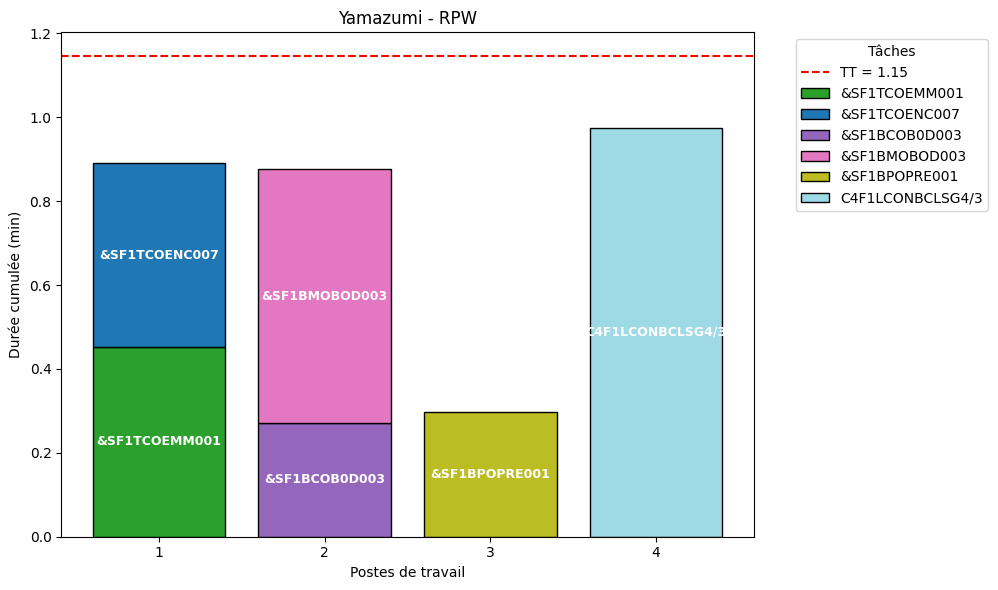

In [ ]:
#df['PRED'] = df['PRED'].fillna('').apply(lambda x: [] if x == '' else [i.strip() for i in str(x).split(',')])
#tasks = {row['Code']: {'duration': row['TIME'], 'predecessors': row['PRED']} for _, row in df.iterrows()}
#TT = 15  # Exemple de Takt Time
ws = rpw_balanced_line(tasks, TT)
plot_yamazumi(ws, tasks, TT)